In [1]:
import cv2
import numpy
import matplotlib.pyplot as plt
from wand.image import Image
import mediapipe as mp
import os

Note to self - I had to install ImageMagick (https://imagemagick.org/script/download.php#windows) and install Wand to convert MEIC to JPG

In [ ]:
!pip install Wand

In [2]:
def plot_image(img):
    fig = plt.figure(figsize=(10,8))
    plt.imshow(img, cmap='gray')
    plt.show()
    
def plot_image_color(img):
    fig = plt.figure(figsize=(10,8))
    plt.imshow(img)
    plt.show()

#### Image Preprocessing Utils

In [3]:
faceDetect = mp.solutions.face_detection
detection = faceDetect.FaceDetection()
RESIZE_DIM = 34

def detect_face_boundaries(img):
    IMG_H, IMG_W = img.shape[0], img.shape[1]
    processed = False
    boundary_tuple = None
    result = detection.process(img)
    
    if result.detections:
        face = result.detections[0]
        box_info = face.location_data.relative_bounding_box
        x,y,w,h = int(box_info.xmin*IMG_W), int(box_info.ymin*IMG_H), int(box_info.width*IMG_W), int(box_info.height*IMG_H)
        boundary_tuple = (y,y+h,x,x+w)
        processed = True
        
    return boundary_tuple, processed

def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)
    
    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))
    
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0
    
    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1
    
    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1
    
    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    
    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''
    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return auto_result

### JPG Transformation Function
- backbone of the preprocessing pipeline

In [ ]:
def apply_jpg_transform(img, color=False):
    # detect face and crop
    face_boundaries, face_detected = detect_face_boundaries(img)
    if not face_detected:
        return None, False
    
    R_START, R_END, C_START, C_END = face_boundaries
    # apply contrast balancing
    img = automatic_brightness_and_contrast(img)
    
    if not color:
        # Grayscale Processing
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    elif color:
        # Color Processing
        pass
    
    cropped_face = img[R_START:R_END, C_START:C_END]
    
    downsampled = cv2.resize(cropped_face, (RESIZE_DIM, RESIZE_DIM), interpolation = cv2.INTER_CUBIC)
    # get the width of the photo
    n = downsampled.shape[1] 
    n = n-1 if n%2==1 else n
    downsampled = cv2.resize(downsampled,(n, n))
    return downsampled, True

### Photo OS Shuffling
- Note, these directories may need to be updated to properly fit within the confines of whichever file structure they find themselves in. At the time of this message, the datasets used are hidden from this github repo.

In [5]:
SOURCE_DIR="../images"
TARGET_JPG_DIR="../images_jpg"
MASK_JGP_DIR="../images_jpg_mask"
NO_MASK_JGP_DIR="../images_jpg_no_mask"
TARGET_GRAY_NO_MASK_DIR="../images_gray_transformed_no_mask"
TARGET_GRAY_MASK_DIR="../images_gray_transformed_mask"
TARGET_COLOR_NO_MASK_DIR="../images_color_transformed_no_mask"
TARGET_COLOR_MASK_DIR="../images_color_transformed_mask"

def convert_heic_to_jpg(filename):
    img_name, file_type = filename.split('.')
    img = Image(filename=f"{SOURCE_DIR}/{filename}")
    img.format = 'jpg'
    img.save(filename=f"{TARGET_JPG_DIR}/{img_name}.JPG")
    img.close()

def convert_pictures_to_jpg():     
    for heic_filename in os.listdir(f'{SOURCE_DIR}'):
        img_name, file_type = heic_filename.split('.')
        img = convert_heic_to_jpg(heic_filename)

def process_pictures(color=False):
    # for no mask
    target_no_mask_dir = TARGET_COLOR_NO_MASK_DIR if color else TARGET_GRAY_NO_MASK_DIR
    target_mask_dir = TARGET_COLOR_MASK_DIR if color else TARGET_GRAY_MASK_DIR
    
    for jpg_filename in os.listdir(f'{NO_MASK_JGP_DIR}'):
        img_name, file_type = jpg_filename.split('.')
        img = cv2.imread(f'{NO_MASK_JGP_DIR}/{img_name}.JPG')
        img, processed = apply_jpg_transform(img, color=color)
        if processed:
            cv2.imwrite(f'{target_no_mask_dir}/{img_name}.JPG', img)
    
    # for mask
    for jpg_filename in os.listdir(f'{MASK_JGP_DIR}'):
        img_name, file_type = jpg_filename.split('.')
        img = cv2.imread(f'{MASK_JGP_DIR}/{img_name}.JPG')
        img, processed = apply_jpg_transform(img, color=color)
        if processed:
            cv2.imwrite(f'{target_mask_dir}/{img_name}.JPG', img)

## Convert HIEC FILES TO JPG
- manual sorting of mask vs non mask images is required

In [4]:
convert_pictures_to_jpg()

## Preprocessing Images

In [68]:
process_pictures(color=False)

In [69]:
process_pictures(color=True)

### VIEWING PREPROCESSED IMAGES

In [30]:
nomask = ['IMG_5459', 'IMG_5493', 'IMG_837064129', 'IMG_837063099']
mask = ['IMG_5576', 'IMG_837068269', 'IMG_5663', 'IMG_837068657']
nomaskimg = [cv2.imread(f"{TARGET_GRAY_NO_MASK_DIR}/{name}.jpg", cv2.IMREAD_GRAYSCALE) for name in nomask]
maskimg = [cv2.imread(f"{TARGET_GRAY_MASK_DIR}/{name}.jpg", cv2.IMREAD_GRAYSCALE) for name in mask]

#### No Mask

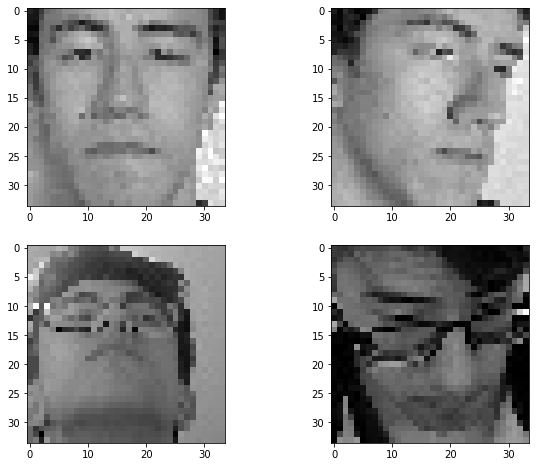

In [32]:
fig, axes = plt.subplots(2,2, figsize=(10,8))
axes[0][0].imshow(nomaskimg[0], cmap='gray')
axes[0][1].imshow(nomaskimg[1], cmap='gray')
axes[1][0].imshow(nomaskimg[2], cmap='gray')
axes[1][1].imshow(nomaskimg[3], cmap='gray')
plt.savefig('nomaskpre.png')
plt.show()

#### Mask

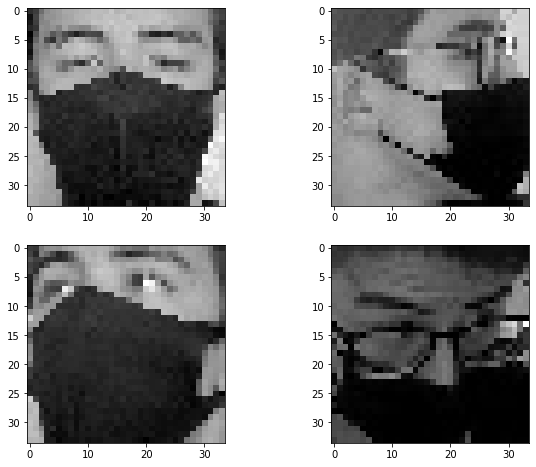

In [33]:
fig, axes = plt.subplots(2,2, figsize=(10,8))
axes[0][0].imshow(maskimg[0], cmap='gray')
axes[0][1].imshow(maskimg[1], cmap='gray')
axes[1][0].imshow(maskimg[2], cmap='gray')
axes[1][1].imshow(maskimg[3], cmap='gray')
plt.savefig('maskpre.png')
plt.show()